In [2]:
import pandas as pd
import numpy as np

day = -2
round_no = 1

prc_df = pd.read_csv(rf"prices_round_{round_no}_day_{day}.csv", sep=';')
trades_df = pd.read_csv(rf"trades_round_{round_no}_day_{day}.csv", sep=';')

## RAINFOREST-RESIN (Interpretation and Strategy)

+ Doing some analysis you can determine that the "Fair Mid-Price" against which your PnL is determined was calculated using the mid point of the bid price with max bid vol and ask price with max ask vol.
  > - This can be proven by just buying one quantity at the beginning and tracking the PnL.
  > - Irrelevant for RESIN, due to a ficed fair price of 10,000, but will be useful for KELP.
+ We know the fair price of RAINFOREST RESIN is 10,000. Can be determined using multiple ways including $ \frac{\text{Max vol BID} + \text{Max vol ASK}}{2} $ which remains constant at 10,000.
+ $ \text{Max vol BID} = \text{Bid Price}_{j} \quad j = max(\text{Bid Volume}_i), i = 1,2..,N $

+ Possible buy amount = $ max(0, \text{limit - current position}) $
+ Possible sell amount = -$ max(0, \text{limit + current position}) $

In [3]:
prc_df_resin = prc_df[prc_df['product'] == "RAINFOREST_RESIN"]
trades_df_resin = trades_df[trades_df["symbol"] == "RAINFOREST_RESIN"]

In [4]:
trades_df_resin = trades_df_resin.drop(columns=["buyer","seller","currency"])

In [5]:
trades_df_resin = (
    trades_df_resin
    .groupby(['timestamp', 'price'], as_index=False)
    .agg({'quantity': 'sum'})
)

In [6]:
trades_df_resin = trades_df_resin.rename(
    columns={
        'price': 'market order price',
        'quantity': 'market order quantity'
    }
)

In [7]:
merged_resin_df = prc_df_resin.merge(
    trades_df_resin[['timestamp', 'market order price', 'market order quantity']],
    on='timestamp',
    how='inner')


In [8]:
fair_price = 10000
tick = 1

merged_resin_df['scalp_price'] = np.where(
    merged_resin_df['market order price'] < fair_price,
    merged_resin_df['market order price'] + tick,
    merged_resin_df['market order price'] - tick
)

merged_resin_df['expected_profit_scalp'] = np.where(
    merged_resin_df['market order price'] < fair_price,
    (fair_price - merged_resin_df['scalp_price']) * merged_resin_df['market order quantity'],
    (merged_resin_df['scalp_price'] - fair_price) * merged_resin_df['market order quantity']
)

total_hypo_pnl = merged_resin_df['expected_profit_scalp'].sum()
print(f"Total expected profit posting aggressive limits: {total_hypo_pnl}")

Total expected profit posting aggressive limits: 10849.0


In [9]:
merged_resin_df['remaining_qty_at_best_bid'] = np.where(
    merged_resin_df['market order price'] < fair_price,
    np.maximum(
        merged_resin_df['market order quantity'] - merged_resin_df['bid_volume_1'],
        0
    ),
    0
)

merged_resin_df['profit_at_best_bid'] = (
    merged_resin_df['remaining_qty_at_best_bid'] *
    (fair_price - merged_resin_df['bid_price_1'])
)

merged_resin_df['remaining_qty_at_best_ask'] = np.where(
    merged_resin_df['market order price'] > fair_price,
    np.maximum(
        merged_resin_df['market order quantity'] - merged_resin_df['ask_volume_1'],
        0
    ),
    0
)

merged_resin_df['profit_at_best_ask'] = (
    merged_resin_df['remaining_qty_at_best_ask'] *
    (merged_resin_df['ask_price_1'] - fair_price)
)


total_profit_best_bid = merged_resin_df['profit_at_best_bid'].sum()
print(f"Total profit joining the best‐bid queue: {total_profit_best_bid}")

total_profit_best_ask = merged_resin_df['profit_at_best_ask'].sum()
print(f"Total profit joining the best‐ask queue: {total_profit_best_ask}")

Total profit joining the best‐bid queue: 2248
Total profit joining the best‐ask queue: 2406


In [10]:
print("Scalp strategy P&L:         ", total_hypo_pnl)
print("Total P&L joining the QUEUE: ", total_profit_best_bid+total_profit_best_ask)

Scalp strategy P&L:          10849.0
Total P&L joining the QUEUE:  4654


+ While doing research using previous years GitHub we descovered that some teams decided to joing the best bid or best ask when the "edge" (defined as the difference between best bid and fair price, best ask and fair price) was small enough.
+ Why would this be wrong?
  > - The game mechanics run on a price-time priority, before sending our orders we get a snapshot of the existing book, after sending our orders the bots decide to trade.
  > - If we imagine a hypothetical book with the best bid = 9998 and the best bid amount as 1, and we decided to join the QUEUE at that price level, the market order would have to be greater than 1 in order for our order to get executed.
  > - We ran an anlysis to check for the expected profit when we join the Queue as opposed to scalping the best bid for a tick after which our conclusion was that joining the bid/ask queue was never more profitable than scalping.
  > - for the lack of more appropriate term we refer scalping here as beating the best bid by a tick or best ask by a tick, tick = 1.


In [11]:
fair_price = 10000


cond_a = (
    (merged_resin_df['market order price'] < fair_price) &
    (merged_resin_df['ask_price_1']      < fair_price)
)
freq_a = cond_a.sum()


cond_b = (
    (merged_resin_df['market order price'] > fair_price) &
    (merged_resin_df['bid_price_1']       > fair_price)
)
freq_b = cond_b.sum()


total_events = len(merged_resin_df)
pct_a = freq_a / total_events * 100
pct_b = freq_b / total_events * 100

print(f"Events where market < fair & best-ask < fair: {freq_a} ({pct_a:.1f}%)")
print(f"Events where market > fair & best-bid > fair: {freq_b} ({pct_b:.1f}%)")


Events where market < fair & best-ask < fair: 477 (21.7%)
Events where market > fair & best-bid > fair: 479 (21.7%)




  
+ We observe there are times when the best ask is lower than fair price and best bid is higher than fair price. It leads to the obvious conclusion that at each iteration we should look for this "Arbitrage" opportunity and buy/sell any and everything we could.
+ Why would this be wrong?
  > - Using the above analysis we observe there are 477 events where the best ask is less than fair price but there was a market sell order order, where the rational expected outcome would be a market buy order as we observe a mis pricing.
  > - Which is why our algorithm decides to send a market buy only for the ASK Amount when it is lower than fair price and sends remaining buy orders 1 tick above the best buy to capture the discussed irrationality.


+ Our final decision rule made sure our inventory remained closer to 0.
  > - If our inventory (current position is positive) and the best bid > fair price, also the second best bid > 9999, i.e second best bid = fair price. We would send everything at the second best bid inorder to capture the mispricing (best bid > fair price) and clear our remaining inventory at the "fair price" (second best bid).

### Our Implementation
```
 def resin_fair_value_arb(state: Status, fair_price):
        """
        Execute a fair value arbitrage strategy for RAINFOREST_RESIN.

        This strategy identifies arbitrage opportunities by comparing 
        the current best bid and ask prices against a known fair price.
        It attempts to sell when bids are overpriced (above 9999) or buy
        when asks are underpriced (below 10001). If no clear arbitrage 
        is available, it performs market making.

        Args:
            state (Status): The market state for RAINFOREST_RESIN.
            fair_price (float): Theoretical fair price (currently unused).

        Returns:
            list[Order]: A list of Order objects representing buy/sell decisions.
        """

        orders = []

        # arbitrage opportunity on the bids so sell here
        if state.best_bid > 9999:
            if state.second_bid is not None and state.second_bid > 9999 and state.rt_position > 0:
                orders.append(Order(state.product, state.second_bid, -state.possible_sell_amt))
                if state.maxamt_bidprc + 1 < state.second_bid:
                    orders.append(Order(state.product, state.maxamt_bidprc + 1, state.possible_buy_amt))
                else:
                    orders.append(Order(state.product, state.second_bid-1, state.possible_buy_amt))
            else:
                orders.append(Order(state.product, state.best_bid, -state.best_bid_amount))
                remaining_order = state.possible_sell_amt - state.best_bid_amount
                if remaining_order > 0:
                    orders.append(Order(state.product, state.best_ask-1, - remaining_order))
                
                if state.second_bid is not None and state.second_bid + 1 < state.best_bid:
                    orders.append(Order(state.product, state.second_bid+1, state.possible_buy_amt))
                elif state.maxamt_bidprc + 1 < state.best_bid:
                    orders.append(Order(state.product, state.maxamt_bidprc+1, state.possible_buy_amt))
        
        # arbitrage opportunity on the asks so buy here
        elif state.best_ask < 10001:
            if state.second_ask is not None and state.second_ask < 10001 and state.rt_position < 0:
                orders.append(Order(state.product, state.second_ask, state.possible_buy_amt))
                if state.maxamt_askprc - 1 > state.second_ask:
                    orders.append(Order(state.product, state.maxamt_askprc - 1, -state.possible_sell_amt))
                else:
                    orders.append(Order(state.product, state.second_ask + 1, -state.possible_sell_amt))
            else:
                orders.append(Order(state.product, state.best_ask, abs(state.best_ask_amount)))
                remaining_order = state.possible_buy_amt - abs(state.best_ask_amount)
                if remaining_order > 0:
                    orders.append(Order(state.product, state.best_bid + 1, remaining_order))
                if state.second_ask is not None and state.second_ask - 1 > state.best_ask:
                    orders.append(Order(state.product, state.second_ask -1, -state.possible_sell_amt))
                elif state.maxamt_askprc - 1 > state.best_ask:
                    orders.append(Order(state.product, state.maxamt_askprc - 1, -state.possible_sell_amt))

        # No arbitrage opportunity, simple market making
        else:
            if state.bid_ask_spread > 1:
                orders.append(Order(state.product, state.best_bid+1, state.possible_buy_amt))
                orders.append(Order(state.product, state.best_ask-1, -state.possible_sell_amt))
            else:
                orders.append(Order(state.product, state.best_bid, state.possible_buy_amt))
                orders.append(Order(state.product, state.best_ask, -state.possible_sell_amt))

        return orders
```

## KELP

In [12]:
prc_df_kelp = prc_df[prc_df['product'] == "KELP"]
trades_df_kelp = trades_df[trades_df["symbol"] == "KELP"]
trades_df_kelp = trades_df_kelp.drop(columns=["buyer","seller","currency"])

In [13]:
trades_df_kelp = (
    trades_df_kelp
    .groupby(['timestamp', 'price'], as_index=False)
    .agg({'quantity': 'sum'})
)
trades_df_kelp = trades_df_kelp.rename(
    columns={
        'price': 'market order price',
        'quantity': 'market order quantity'
    }
)

In [14]:
merged_kelp_df = prc_df_kelp.merge(
    trades_df_kelp[['timestamp', 'market order price', 'market order quantity']],
    on='timestamp',
    how='inner')

In [15]:
merged_kelp_df

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,market order price,market order quantity
0,-2,0,KELP,1998,26,NaN,NaN,NaN,NaN,2002,26,NaN,NaN,NaN,NaN,2000.0,0.0,2002.0,1
1,-2,100,KELP,2000,5,1999.0,6.0,1998.0,20.0,2002,20,NaN,NaN,NaN,NaN,2001.0,0.0,2002.0,6
2,-2,1000,KELP,1999,24,NaN,NaN,NaN,NaN,2001,8,2002.0,24.0,NaN,NaN,2000.0,0.0,1999.0,10
3,-2,1100,KELP,1999,25,NaN,NaN,NaN,NaN,2001,3,2002.0,26.0,NaN,NaN,2000.0,0.0,1999.0,1
4,-2,1500,KELP,1999,27,NaN,NaN,NaN,NaN,2002,27,NaN,NaN,NaN,NaN,2000.5,0.0,2002.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2737,-2,997900,KELP,2026,21,NaN,NaN,NaN,NaN,2029,21,NaN,NaN,NaN,NaN,2027.5,0.0,2026.0,12
2738,-2,998000,KELP,2026,25,NaN,NaN,NaN,NaN,2027,4,2029.0,26.0,NaN,NaN,2026.5,0.0,2026.0,1
2739,-2,998000,KELP,2026,25,NaN,NaN,NaN,NaN,2027,4,2029.0,26.0,NaN,NaN,2026.5,0.0,2027.0,4
2740,-2,998900,KELP,2029,1,2026.0,22.0,NaN,NaN,2030,22,NaN,NaN,NaN,NaN,2029.5,0.0,2029.0,1


## KELP Strategy

+ Calculating the "Fair Mid-Price using the same method as RESIN. 
+ Fair-Price can be determined using $ \frac{\text{Max vol BID} + \text{Max vol ASK}}{2} $.
+ $ \text{Max vol BID} = \text{Bid Price}_{j} \quad j = max(\text{Bid Volume}_i), i = 1,2..,N $

+ Possible buy amount = $ max(0, \text{limit - current position}) $
+ Possible sell amount = -$ max(0, \text{limit + current position}) $

+ The difference between RESIN and KELP was the variable "Fair Mid-Price" of KELP.
+ While working on this competition I was also going through a popular paper on Optimal Execution by Almgren and Chriss

#### If meta-order is to sell (Almgren and Chriss)

+ assuming a random walk, total proceeds K from the sales can be calculated:
  $$ K = \sum_{k=1}^{N} n_{k} P_{k} = S_{o} P_{o} + \sum_{k=1}^{N} ( g(v_{k})* \tau + \sigma * Z*\sqrt{\tau} )*x_{k} + \sum_{k=1}^{N} n_{k} h(v_{k}) $$

+ $ \sum_{k=1}^{N} n_{k} P_{k} $ = Total proceeds of the n shares sold over the child orders executed in period k times the average price of those executions.

+ $ S_{o} P_{o} $ = Total proceeds if we sold entire meta order at t=0

+ $ \sum_{k=1}^{N} ( g(v_{k})* \tau + \sigma * Z*\sqrt{\tau} )*x_{k} $ = Total permanent price impact in period k of the shares sold on remaining shares in the meta-order.

+ $  Z*\sqrt{\tau}  $ = price volatility

+ $  \sum_{k=1}^{N} n_{k} h(v_{k}) $ = Total short-term impact of the shares sold in period K.

+ The paper focuses on optimal execution of a large block of shares and aims to minimize the price risk we assume by carrying the inventory at each time interval while also minimizing the transaction costs.
+ I looked into this to see if the price fluctuations could be divided into 'Temporary' and 'Permanent' price impacts based on market orders but due to time and man-power limitations decided not to pursue this quest.
+ However we couldn't ignore the variance added to our PnL due to carrying a large inventory, we decided to make sure all our strategies were a function of current inventory.
+ I saw the previous years' teams and the teams on discord talk about a linear regression approach which frankly seemed a bit naive and redundant, and it made more sense that IMC would have the solution hidden in the order book pattern, the relatively high amount of market orders futher reinforced this, so I began exploring it further.

+ We came down to 8 different strategies that we decided to deploy:
    > - Strategy 1: Orderbook Gap Arbitrage
    > - Strategy 2: Secondary Gap Arbitrage Based on Volume Anchors
    > - Strategy 3: Clear Inventory at 'Fair Price'
    > - Strategy 4: Top-Layer Skew analysis
    > - Strategy 5: Market Maker Order Analysis
    > - Strategy 6: Volatility Breakout Trading
    > - Strategy 7: Second Top Layer Skew
    > - Strategy 8: Final Fallback Market-Making


#### Strategy 1: Orderbook Gap Arbitrage

+ Goal: Exploit a large “hole” between the top‐of‐book (best_bid/best_ask) and the level with most resting size (maxamt_bidprc/maxamt_askprc).
+ Threshold: gap > 2 ticks.
+ Action:
  > - If bids are thin (bid_gap>2), we cross the spread by selling at our best_bid, then immediately attempt to re-buy at the heavier depth level (maxamt_bidprc+1).
  > - Symmetrically for the ask side.
```
    @staticmethod
    def kelp_orderbook_gap_arb(state: Status):
        """
        Strategy 1: KELP Orderbook Gap Arbitrage

        Looks for unusually large gaps between top bid/ask prices and the 
        prices with maximum volume on each side of the order book. 
        Executes aggressive trades if gaps are larger than a threshold (2).

        Args:
            state (Status): Market status object for KELP.

        Returns:
            list[Order]: A list of buy/sell orders based on detected gaps.
        """

        orders = []

        if state.bid_gap > 2:
            orders.append(Order(state.product, state.best_bid, -state.possible_sell_amt))
            orders.append(Order(state.product, state.maxamt_bidprc + 1, state.possible_buy_amt))
        
        elif state.ask_gap > 2:
            orders.append(Order(state.product, state.best_ask, state.possible_buy_amt))
            orders.append(Order(state.product, state.maxamt_askprc - 1, -state.possible_sell_amt))
        
        return orders

```

#### Strategy 2: Secondary Gap Arbitrage Based on Volume Anchors

+ Goal: A stricter version of Strategy 1 that only fires when the largest volume level coincides with the top of book.
+ Threshold: smaller gap (>1 tick) but requires price+volume alignment for extra confidence.
```
    @staticmethod
    def kelp_second_orderbook_gap_arb(state: Status):
        """
        Strategy 2: Secondary Gap Arbitrage Based on Volume Anchors

        Builds on the original orderbook gap arbitrage, but with additional
        filters based on volume locations. Targets situations where the 
        best ask equals the ask with the most volume, or vice versa.

        Args:
            state (Status): Market status object for KELP.

        Returns:
            list[Order]: A list of arbitrage orders under stricter conditions.
        """

        orders = []
        
        if state.bid_gap > 1 and state.best_ask==state.maxamt_askprc:
            orders.append(Order(state.product, state.best_bid, -state.possible_sell_amt))
            orders.append(Order(state.product, state.maxamt_bidprc + 1, state.possible_buy_amt))
        
        elif state.ask_gap > 1 and state.best_bid==state.best_bid_amount:
            orders.append(Order(state.product, state.best_ask, state.possible_buy_amt))
            orders.append(Order(state.product, state.maxamt_askprc - 1, -state.possible_sell_amt))

        return orders
```

#### Strategy 3: Clear Inventory at 'Fair Price'

+ Goal: Reduce large inventory positions when the market price is within fair_price_threshold of our reference fair price (maxamt_midprc).
+ Parameters:

    > - threshold_position: how large a position triggers an unwind (default 20).

    > - fair_price_threshold: max ticks away from fair price we’re willing to clear (default 0).
+ Action: Place aggressive orders at the top of book to offload (or cover) and “ladder” a counter-order one tick away to maintain market presence.
```
    @staticmethod
    def kelp_clear_inventory_at_fair_price(state: Status, threshold_position = 20, fair_price_threshold = 0):
        """
        Strategy 3: Clear Inventory Near Fair Price

        Tries to offload excess inventory (position > threshold) if current
        prices are close to a perceived fair price (maxamt_midprc).

        Args:
            state (Status): Market status object for KELP.
            threshold_position (int, optional): Position size threshold. Defaults to 40.
            fair_price_threshold (int, optional): Maximum deviation allowed from fair price. Defaults to 0.

        Returns:
            list[Order]: Orders to clear inventory at prices near maxamt_midprc.
        """

        orders = []

        if state.rt_position > threshold_position and state.maxamt_midprc - state.best_bid <= fair_price_threshold:
            orders.append(Order(state.product, state.best_bid, -state.possible_sell_amt))
            orders.append(Order(state.product, state.best_bid - 1, state.possible_buy_amt))
        
        elif state.rt_position < -threshold_position and state.best_ask - state.maxamt_midprc <= fair_price_threshold:
            orders.append(Order(state.product, state.best_ask, state.possible_buy_amt))
            orders.append(Order(state.product, state.best_ask + 1, -state.possible_sell_amt))
        
        return orders
```

#### Strategy 4: Top-Layer Skew Analysis

+ Top-Layer Skew = $ ln( \frac{\text{Bid Volume 1}}{\text{Ask volume 1}} ) $
+ spread = $ \text{Ask Price 1} - \text{Bid Price 1} $
+ Goal: When one side’s top‐of‐book volume dominates and the book is extremely liquid(spread = 1), fade the imbalance by posting passive quotes on the opposite side.
  
```
    @staticmethod
    def kelp_toplyr_skew_arbitrage(state: Status,skew_thresh = 1, spread_thresh = 2, threshold_position = 40):
        """
        Strategy 4: Top-Layer Skew Arbitrage

        Uses the imbalance between top bid and ask volumes (top layer skew)
        as a trading signal. If skew is significant and spread is narrow,
        it triggers buys or sells with laddering for inventory rebalancing.

        Args:
            state (Status): Market status object for KELP.
            skew_thresh (float, optional): Minimum skew threshold. Defaults to 0.
            spread_thresh (int, optional): Maximum allowed bid-ask spread. Defaults to 2.
            threshold_position (int, optional): Max allowable position before skipping trades. Defaults to 40.

        Returns:
            list[Order]: Buy or sell orders depending on skew direction and thresholds.
        """

        orders = []

        if state.top_lyr_skew > skew_thresh and state.bid_ask_spread < spread_thresh and state.rt_position < threshold_position:
            orders.append(Order(state.product, state.best_ask, state.possible_buy_amt))
            orders.append(Order(state.product, state.best_ask + 1, -state.possible_sell_amt))

        
        elif state.top_lyr_skew < -skew_thresh and state.bid_ask_spread < spread_thresh and state.rt_position > -threshold_position:
            orders.append(Order(state.product, state.best_bid, -state.possible_sell_amt))
            orders.append(Order(state.product, state.best_bid - 1, state.possible_buy_amt))

        return orders
```

#### Strategy 5: Market-Maker Order Analysis

+ We observed that it was a common knowledge that IMC used the 'Max VOL BID' and 'Max VOL ASK' for price formation.
+ Where $ \text{Max vol BID} = \text{Bid Price}_{i} \quad i = max(\text{Bid Volume}_i), i = 1,2..,N $
+ It felt wrong to not have a strategy that was a function of this Market-maker's Behaviour.
+ If market maker wanted to Buy "MORE" than it wanted to sell we decided to scalp the market maker's bid and void the ask & Vice-Versa. This seemed to stop us from getting our bid orders executed at local maxima.

```
    @staticmethod
    def kelp_market_maker_analysis(state: Status, market_maker_skew_thresh = 0.4):
        """
        Strategy 5: Market Maker Layer Analysis

        Analyzes whether best bid/ask levels align with volume-heavy layers.
        Based on skew, places passive orders one tick away from the book,
        aiming for predictable fills without crossing the spread.

        Args:
            state (Status): Market status object for KELP.
            market_maker_skew_thresh (float, optional): Threshold for skew detection. Defaults to 0.3.

        Returns:
            list[Order]: Market-making orders centered on strong liquidity levels.
        """

        orders = []

        if state.best_ask == state.maxamt_askprc and state.best_bid == state.maxamt_bidprc:
            
            if state.top_lyr_skew > market_maker_skew_thresh:
                orders.append(Order(state.product, state.maxamt_askprc + 1, -state.possible_sell_amt))
                orders.append(Order(state.product, state.maxamt_bidprc + 1, state.possible_buy_amt))
            
            elif state.top_lyr_skew < -market_maker_skew_thresh:
                orders.append(Order(state.product, state.maxamt_askprc - 1, -state.possible_sell_amt))
                orders.append(Order(state.product, state.maxamt_bidprc - 1, state.possible_buy_amt))
            
            else:
                orders.append(Order(state.product, state.maxamt_askprc - 1, -state.possible_sell_amt))
                orders.append(Order(state.product, state.maxamt_bidprc + 1, state.possible_buy_amt))
        
        return orders
```

#### Strategy 6: Volatility Breakout Trading

+ Metric: standardized_log_return measures z-score of recent price change.
+ Goal: Catch momentum breakouts: unwind positions if price moves significantly beyond your average fill price.
+ Outcome: Purely aggressive (cross‐spread) orders to exit or flip the position.
```
    @staticmethod
    def kelp_volatility_trading(state: Status, standardized_return_threshold=3):
        """
        Strategy 6: Volatility Breakout Trading

        Leverages standardized log return to detect breakout conditions.
        Enters or exits positions when price deviates significantly from
        recent average execution prices.

        Args:
            state (Status): Market status object for KELP.
            standardized_return_threshold (float, optional): Return threshold for action. Defaults to 2.5.

        Returns:
            list[Order]: Orders to exploit directional momentum (breakouts).
        """
        orders = []

        if state.standardized_log_return > standardized_return_threshold and state.best_bid > state.my_avg_execution:
            if state.rt_position > 0:
                orders.append(Order(state.product, state.best_bid, -state.rt_position))
            else:
                orders.append(Order(state.product, state.best_bid, -abs(state.best_bid_amount)))

        elif state.standardized_log_return < -standardized_return_threshold and state.best_ask < state.my_avg_execution:
            if state.rt_position < 0:
                orders.append(Order(state.product, state.best_ask, abs(state.rt_position)))
            else:
                orders.append(Order(state.product, state.best_ask, abs(state.best_ask_amount)))

        return orders
```

#### Strategy 7: Second Top-Layer Skew (Aggressive)

+ Goal: A more aggressive skew play when the spread is wide—assumes reversion into heavy‐volume side.

```
    @staticmethod
    def kelp_second_toplyr_skew(state: Status, skew_thresh = 3, spread_thresh = 2, threshold_position = 40):
        """
        Strategy 7: Second Top Layer Skew

        A more aggressive version of the top layer skew strategy, triggered only when:
        - The skew is very strong (beyond skew_thresh)
        - The spread is wide (greater than spread_thresh)
        - Position size allows room to act

        Buys low and sells high based on skew dominance, assuming mean reversion or continuation.

        Args:
            state (Status): Market status object for KELP.
            skew_thresh (float, optional): Strong skew threshold. Defaults to 3.
            spread_thresh (int, optional): Minimum spread to allow action. Defaults to 2.
            threshold_position (int, optional): Max position size for trade. Defaults to 40.

        Returns:
            list[Order]: Orders to exploit highly skewed book with sufficient spread.
        """

        orders = []

        if state.top_lyr_skew > skew_thresh and state.bid_ask_spread > spread_thresh and state.rt_position < threshold_position:
                orders.append(Order(state.product, state.best_ask, -state.possible_sell_amt))
                orders.append(Order(state.product, state.best_bid - 1, state.possible_buy_amt))
        
        elif state.top_lyr_skew < -skew_thresh and state.bid_ask_spread > spread_thresh and state.rt_position > -threshold_position:
                orders.append(Order(state.product, state.best_bid, state.possible_buy_amt))
                orders.append(Order(state.product, state.best_ask + 1, -state.possible_sell_amt))
        
        return orders
```

#### Strategy 8: Final Fallback Market-Making

+ If the spread is wide, you can sit off‐spread at deeper levels to pick up passive fills with better expected edge.

+ If tight, simply post at best bid/ask to capture the spread.

```
    @staticmethod
    def kelp_final(state: Status, spread_thresh = 2):
        """
        Strategy 8: Fallback Final Strategy

        A basic two-sided market-making fallback strategy used when all other
        strategies fail to generate actionable signals.

        Places passive orders at favorable prices based on spread:
        - If spread is wide, places further from mid
        - If tight, stays at best bid/ask

        Args:
            state (Status): Market status object for KELP.
            spread_thresh (int, optional): Minimum spread to use max-volume price levels. Defaults to 2.

        Returns:
            list[Order]: Conservative buy and sell orders to stay active in the market.
        """

        orders = []

        if state.bid_ask_spread > spread_thresh:
            if state.rt_position == 0:
                pos_fact = 0
            else:
                pos_fact = state.rt_position*(int(round(np.log(abs(state.rt_position)))))/abs(state.rt_position) 

        
            orders.append(Order(state.product, int(round(state.maxamt_askprc - 1)), -state.possible_sell_amt))
            orders.append(Order(state.product, int(round(state.maxamt_bidprc + 1)), state.possible_buy_amt))
        else:
            orders.append(Order(state.product, state.best_ask, -state.possible_sell_amt))
            orders.append(Order(state.product, state.best_bid, state.possible_buy_amt))

        return orders
```

## Conclusion

+ We decided the order of strategies and the parameters using a grid search. Once we achieved a PnL around 1,500 on the tutorial round and 6-7,000 on the backtest we decided to not put more time into this.

In [16]:
prc_df_squid = prc_df[prc_df['product'] == "SQUID_INK"]
trades_df_squid = trades_df[trades_df["symbol"] == "SQUID_INK"]

In [17]:
trades_df_squid = trades_df_squid.drop(columns=["buyer","seller","currency"])

In [18]:
trades_df_squid = (
    trades_df_squid
    .groupby(['timestamp', 'price'], as_index=False)
    .agg({'quantity': 'sum'})
)
trades_df_squid = trades_df_squid.rename(
    columns={
        'price': 'market order price',
        'quantity': 'market order quantity'
    }
)


In [19]:
merged_squid_df = prc_df_squid.merge(
    trades_df_squid[['timestamp', 'market order price', 'market order quantity']],
    on='timestamp',
    how='inner')

In [20]:
prc_df_squid 

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
2,-2,0,SQUID_INK,1998,26,NaN,NaN,NaN,NaN,2002,26,NaN,NaN,NaN,NaN,2000.0,0.0
3,-2,100,SQUID_INK,1999,5,1998.0,26.0,NaN,NaN,2001,20,NaN,NaN,NaN,NaN,2000.0,0.0
7,-2,200,SQUID_INK,1997,31,NaN,NaN,NaN,NaN,2000,1,2001.0,30.0,NaN,NaN,1998.5,0.0
11,-2,300,SQUID_INK,1997,27,NaN,NaN,NaN,NaN,2000,27,NaN,NaN,NaN,NaN,1998.5,0.0
14,-2,400,SQUID_INK,1996,20,NaN,NaN,NaN,NaN,2000,20,NaN,NaN,NaN,NaN,1998.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29986,-2,999500,SQUID_INK,2000,26,NaN,NaN,NaN,NaN,2003,26,NaN,NaN,NaN,NaN,2001.5,0.0
29990,-2,999600,SQUID_INK,2001,30,NaN,NaN,NaN,NaN,2004,30,NaN,NaN,NaN,NaN,2002.5,0.0
29992,-2,999700,SQUID_INK,2001,22,NaN,NaN,NaN,NaN,2005,22,NaN,NaN,NaN,NaN,2003.0,0.0
29994,-2,999800,SQUID_INK,2002,26,NaN,NaN,NaN,NaN,2004,3,2005.0,26.0,NaN,NaN,2003.0,0.0


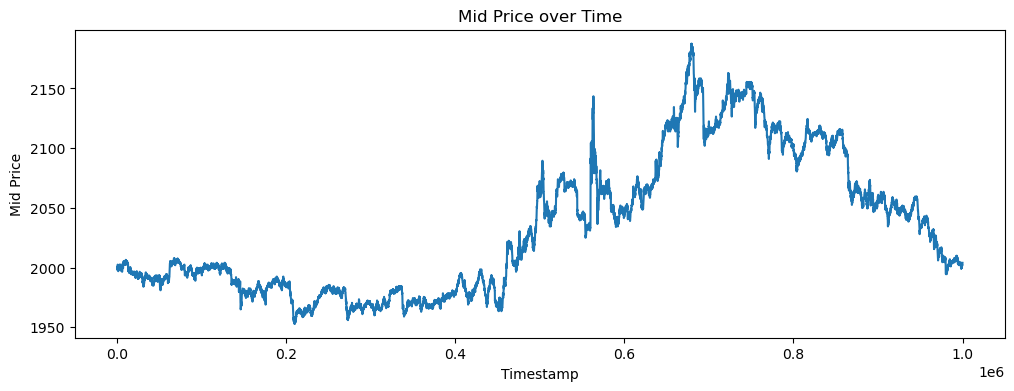

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = prc_df_squid.copy()
df["spread"] = df["ask_price_1"] - df["bid_price_1"]

plt.figure(figsize=(12,4))
plt.plot(df["timestamp"], df["mid_price"])
plt.title("Mid Price over Time")
plt.xlabel("Timestamp"); plt.ylabel("Mid Price")
plt.show()


## Squid Strategy

#### IMC Hint:

+ Squid Ink’s volatility makes large open positions risky.
+ Price spikes tend to mean-revert—track the deviation from a recent average and fade extreme moves for edge.

+ Using First principles our strategy had to depend on how we choose to define the mean, the deviation, and reversion:
  > - Mean: We chose to model the mean using a slow ema with alpha = 0.002, window = 1000 iterations.
  > - Deviation: Due to less time, we just went with a deviation of 12 (eye balling).
  > - Reversion: This was the most import definition, we will discuss later.

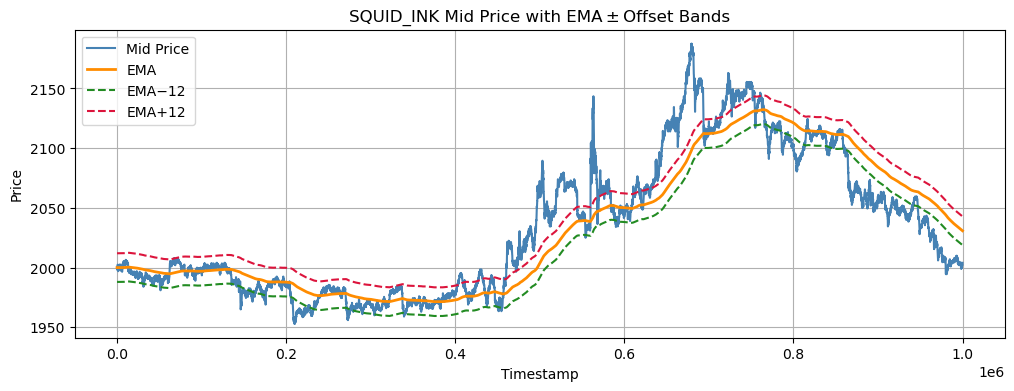

In [22]:
alpha_ema = 0.002
df["mid_price"] = (df["bid_price_1"] + df["ask_price_1"]) / 2
df["ema"]       = df["mid_price"].ewm(alpha=alpha_ema, adjust=False).mean()
offset = 12
df["ema_minus"] = df["ema"] - offset
df["ema_plus"]  = df["ema"] + offset

ema_current = df["ema"].iloc[-1]


plt.figure(figsize=(12,4))
plt.plot(df["timestamp"], df["mid_price"],   label="Mid Price", color="steelblue")
plt.plot(df["timestamp"], df["ema"],         label="EMA",       color="darkorange", lw=2)
plt.plot(df["timestamp"], df["ema_minus"],   label=f"EMA−{offset}", color="forestgreen", ls="--")
plt.plot(df["timestamp"], df["ema_plus"],    label=f"EMA+{offset}", color="crimson",    ls="--")
plt.title("SQUID_INK Mid Price with EMA ± Offset Bands")
plt.xlabel("Timestamp"); plt.ylabel("Price")
plt.legend(loc="upper left"); plt.grid(True)
plt.show()


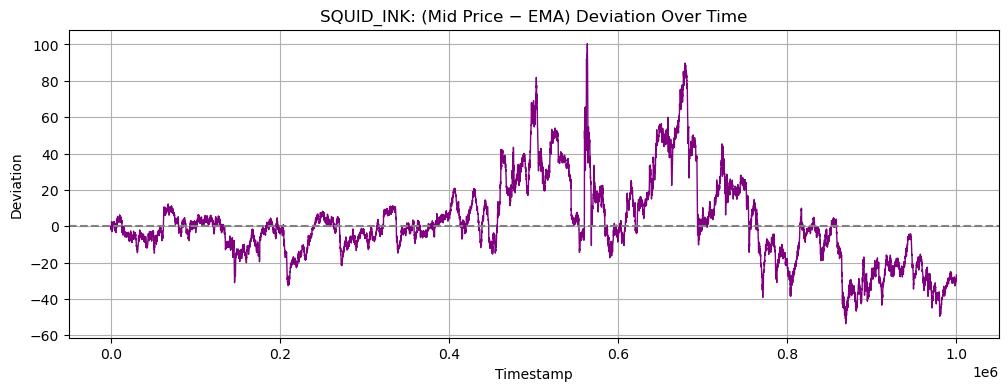

In [23]:
df['deviation'] = df['mid_price'] - df['ema']

plt.figure(figsize=(12,4))
plt.plot(df['timestamp'], df['deviation'], color='purple', lw=1)
plt.axhline(0, color='gray', ls='--')
plt.title('SQUID_INK: (Mid Price − EMA) Deviation Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Deviation')
plt.grid(True)
plt.show()

## SQUID_INK Strategy: Deviation‐Driven, Beta‐Distributed Inventory

### 1. Motivation: Why not a fixed z‐score threshold?  
- Simple “sell when price > $\mu + k\sigma$, buy when price < $\mu - k\sigma$” can backfire if the **mean itself drifts** upward or downward.  
- If you short at a positive deviation and the **EMA continues rising**, your short loses as the “mean” moves against you.  
- Conversely, buying everything below a fixed floor can leave you with a large long in a persistent down‐trend.  
- **Key insight:** inventory should be a **smooth function** of how far price has deviated from your dynamic mean, **not** an all‐or‐nothing trigger.

---

### 2. Mapping Price → Position via a Beta CDF

We construct two Beta‐based cumulative distributions around our EMA backbone:

1. **Mirrored Beta** on $[a,b]$ with $a > b$ for the **buy** side  
2. **Standard Beta** on $[a,b]$ with $a < b$ for the **sell** side  

#### 2.1. Core formulas

- **Beta PDF** on $[0,1]$:  
  $$
    \mathrm{beta\_pdf}(u;\alpha,\beta)
    = \frac{u^{\alpha-1}(1 - u)^{\beta-1}}{B(\alpha,\beta)},\quad
    B(\alpha,\beta)=\frac{\Gamma(\alpha)\,\Gamma(\beta)}{\Gamma(\alpha+\beta)}
  $$
  Returns 0 if $u\not\in[0,1]$.

- **Ascending interval** $[a,b]$ ($a<b$):  
  - Map $x\mapsto u=\tfrac{x-a}{b-a}$.  
  - PDF in $x$-space:  
    $$
      \mathrm{pdf}_x(x)
      = \frac{\mathrm{beta\_pdf}\bigl(\tfrac{x-a}{b-a};\;\alpha_L,\alpha_R\bigr)}{b - a}.
    $$
  - CDF via the trapezoid rule:
    $$
      \mathrm{cdf}_x(x_i)
      = \sum_{k=1}^i \frac{\mathrm{pdf}_x(x_k) + \mathrm{pdf}_x(x_{k-1})}{2}\,\bigl(x_k - x_{k-1}\bigr).
    $$

- **Mirrored interval** $[a,b]$ ($a>b$):  
  - Map $x\mapsto u=\tfrac{a-x}{a-b}$ so $u$ runs $0\to1$ as $x$ runs $a\to b$.  
  - PDF$_x$ and CDF built identically, but on a **descending** grid, then interpolated “up” for queries.

#### 2.2. Dynamic EMA‐based endpoints

Let  
$$
  \mathrm{EMA}_t = \mathrm{EWMA}(\mathrm{mid\_price})_t,\quad
  \mathrm{offset}=12,\;\mathrm{buffer}=5.
$$  
We set:

- **Buy zone**:  
  $$
    a_{\rm buy} = \mathrm{EMA}_t - \mathrm{offset},\quad
    b_{\rm buy} = a_{\rm buy} - \mathrm{buffer}.
  $$
  Build a **mirrored** Beta on $[a_{\rm buy},\,b_{\rm buy}]$.

- **Sell zone**:  
  $$
    a_{\rm sell} = \mathrm{EMA}_t + \mathrm{offset},\quad
    b_{\rm sell} = a_{\rm sell} + \mathrm{buffer}.
  $$
  Build an **ascending** Beta on $[a_{\rm sell},\,b_{\rm sell}]$.



In [33]:
import math
import numpy as np
import matplotlib.pyplot as plt

def beta_pdf(u, alpha, beta):
    """
    Returns the value of the Beta(alpha,beta) PDF at u, for 0<=u<=1.
    Outside [0,1], returns 0.
    """
    if u < 0.0 or u > 1.0:
        return 0.0

    # Beta function in the denominator
    beta_func = math.gamma(alpha)*math.gamma(beta)/math.gamma(alpha + beta)

    # Numerator: u^(alpha-1) * (1-u)^(beta-1)
    return (u**(alpha - 1) * (1.0 - u)**(beta - 1)) / beta_func


### Change the parameters (alphaL & alphaR) to watch how it affects the distribution

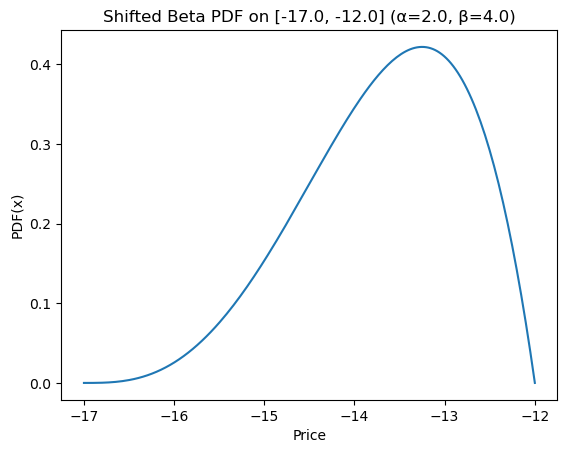

In [35]:
# Parameters
alphaL = 2.0   # shape for left tail
alphaR = 4.0   # shape for right tail
ema    = df['ema'].iloc[-1]
a      = 0 - 12.0      # left endpoint
b      = 0 - 12.0 - 5.0  # right endpoint of mirrored interval

# Make a grid of x-values
x_vals = np.linspace(a, b, 200)

# Convert each x to u in [0,1]
u_vals = (a - x_vals) / (a - b)

# Compute the Beta PDF on [a,b] manually
pdf_u = np.array([beta_pdf(u, alphaL, alphaR) for u in u_vals])

# Scale for [a,b]: pdf_x = pdf_u / |b-a|
pdf_x = pdf_u / abs(b - a)

# Plot
plt.plot(x_vals, pdf_x)
plt.title(f"Shifted Beta PDF on [{b:.1f}, {a:.1f}] (α={alphaL}, β={alphaR})")
plt.xlabel("Price")
plt.ylabel("PDF(x)")
plt.show()

### 3. From CDF → Position

Define scale parameters  
$\mathrm{scale}_{\rm buy} = Q_{\max},\;\mathrm{scale}_{\rm sell} = Q_{\max}$  
(where $Q_{\max}$ is your maximum allowable volume, e.g. 60).

- **Buy‐side inventory** at price $p$:  
  $$
    \mathrm{buy\_pos}(p)
    = \mathrm{scale}_{\rm buy}\;\times\;\mathrm{cdf}_{\rm buy}(p),
  $$
  so that
  - $p = b_{\rm buy}$ (deep) ⇒ $\mathrm{cdf}_{\rm buy}=1$ ⇒ full long  
  - $p = a_{\rm buy}$ (shallow) ⇒ $\mathrm{cdf}_{\rm buy}=0$ ⇒ no long

- **Sell‐side inventory** at price $p$:  
  $$
    \mathrm{sell\_pos}(p)
    = -\,\mathrm{scale}_{\rm sell}\;\times\;\mathrm{cdf}_{\rm sell}(p),
  $$
  so that
  - $p = a_{\rm sell}$ (shallow) ⇒ $\mathrm{cdf}_{\rm sell}=0$ ⇒ no short  
  - $p = b_{\rm sell}$ (deep) ⇒ $\mathrm{cdf}_{\rm sell}=1$ ⇒ full short

- **Net target position**:  
  $$
    \mathrm{pos}_{\rm net}(p)
    = \mathrm{buy\_pos}(p) + \mathrm{sell\_pos}(p).
  $$


In [36]:
import math
import numpy as np
import matplotlib.pyplot as plt

###############################################################################
#                  1) MIRRORED BETA ON [a..b] WHEN a > b (BUY SIDE)
###############################################################################
def beta_pdf(u, alpha, beta):
    """
    Returns Beta(alpha,beta) PDF at u in [0,1].
    Outside [0,1], returns 0.
    """
    if u < 0.0 or u > 1.0:
        return 0.0
    beta_func = math.gamma(alpha) * math.gamma(beta) / math.gamma(alpha + beta)
    return (u**(alpha - 1) * (1.0 - u)**(beta - 1)) / beta_func

def build_mirrored_beta_distribution(a, b, alphaL, alphaR, steps=100):
    """
    Builds a Beta-based distribution on [a..b] when a > b (descending).
    Returns x_vals_desc, pdf_desc, cdf_desc, cdf_at(x).
    """
    if not (a > b):
        raise ValueError("For mirrored distribution, expect a > b.")
    x_vals_desc = np.linspace(a, b, steps)
    def x_to_u(x):
        return (a - x) / (a - b)
    pdf_u_desc = np.array([beta_pdf(x_to_u(x), alphaL, alphaR) for x in x_vals_desc])
    pdf_x_desc = pdf_u_desc / abs(b - a)
    cdf_desc = np.zeros_like(pdf_x_desc)
    for i in range(1, steps):
        dx = x_vals_desc[i] - x_vals_desc[i - 1]
        area = 0.5 * (pdf_x_desc[i] + pdf_x_desc[i - 1]) * abs(dx)
        cdf_desc[i] = cdf_desc[i - 1] + area
    def cdf_at(x):
        if x >= a:
            return 0.0
        if x <= b:
            return 1.0
        x_asc = x_vals_desc[::-1]
        cdf_asc = cdf_desc[::-1]
        return np.interp(x, x_asc, cdf_asc)
    return x_vals_desc, pdf_x_desc, cdf_desc, cdf_at

###############################################################################
#      2) ASCENDING BETA ON [a..b] WHEN a < b (SELL SIDE)
###############################################################################
def build_ascending_beta_distribution(a, b, alphaL, alphaR, steps=100):
    """
    Standard Beta distribution on [a..b], a<b, ascending array.
    Returns x_vals, pdf_x, cdf_x, cdf_at(x).
    """
    if not (a < b):
        raise ValueError("For ascending distribution, expect a < b.")
    x_vals = np.linspace(a, b, steps)
    def x_to_u(x):
        return (x - a) / (b - a)
    pdf_u = np.array([beta_pdf(x_to_u(xx), alphaL, alphaR) for xx in x_vals])
    pdf_x = pdf_u / (b - a)
    cdf_x = np.zeros_like(pdf_x)
    for i in range(1, steps):
        dx = x_vals[i] - x_vals[i - 1]
        area = 0.5 * (pdf_x[i] + pdf_x[i - 1]) * dx
        cdf_x[i] = cdf_x[i - 1] + area
    def cdf_at(x):
        if x <= a:
            return 0.0
        if x >= b:
            return 1.0
        return np.interp(x, x_vals, cdf_x)
    return x_vals, pdf_x, cdf_x, cdf_at

###############################################################################
#            3) BUILD THE "BUY" SIDE (MIRRORED) on [-12, -17]
###############################################################################
alphaL_buy, alphaR_buy = 2.0, 2.0
buy_a, buy_b = -12, -17  # a > b
x_vals_buy, pdf_buy, cdf_buy, cdf_buy_at = build_mirrored_beta_distribution(
    buy_a, buy_b, alphaL_buy, alphaR_buy, steps=100
)

def buy_position(ask_price, scale=50):
    """
    Positive inventory for buying:
      ask=200 => cdf_at(200)=1 => buy=+60
      ask=330 => cdf_at(330)=0 => buy=0
    => buy_position = scale * cdf_at(ask_price)
    """
    return scale * cdf_buy_at(ask_price)

###############################################################################
#           4) BUILD THE "SELL" SIDE (ASCENDING) on [12, 17]
###############################################################################
alphaL_sell, alphaR_sell = 2.0, 2.0
sell_a, sell_b = 12, 17  # a < b
x_vals_sell, pdf_sell, cdf_sell, cdf_sell_at = build_ascending_beta_distribution(
    sell_a, sell_b, alphaL_sell, alphaR_sell, steps=100
)

def sell_position(bid_price, scale=50):
    """
    Negative inventory for selling:
      bid=390 => cdf_at(390)=0 => sell=0
      bid=500 => cdf_at(500)=1 => sell=-60
    => sell_position = -scale * cdf_at(bid_price)
    """
    return -scale * cdf_sell_at(bid_price)



## Try changing the ask & bid to see how our desired position changes (Price = 0)

ask=15, bid=13
buy side = 0.00, sell side = -5.20, total=-5.20


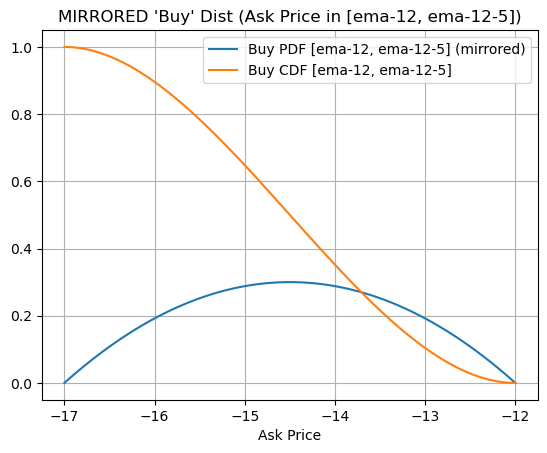

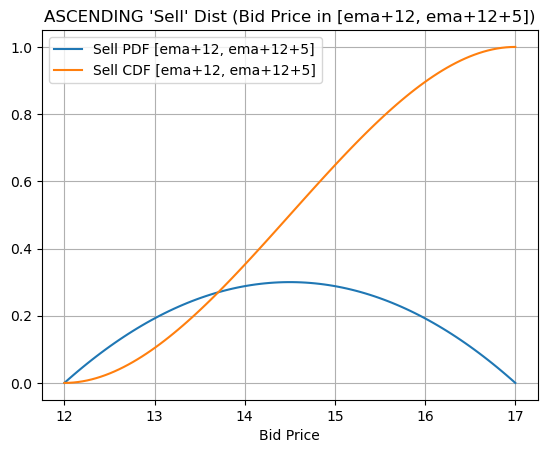

In [39]:
###############################################################################
#                 5) QUICK TEST
###############################################################################
test_ask = 15
test_bid = 13
inv_buy_side = buy_position(test_ask, scale=50)
inv_sell_side = sell_position(test_bid, scale=50)
inv_total = inv_buy_side + inv_sell_side
print(f"ask={test_ask}, bid={test_bid}")
print(f"buy side = {inv_buy_side:.2f}, sell side = {inv_sell_side:.2f}, total={inv_total:.2f}")

###############################################################################
#                6) PLOTTING
###############################################################################
# Plot buy distribution
plt.figure()
plt.plot(x_vals_buy, pdf_buy, label="Buy PDF [ema-12, ema-12-5] (mirrored)")
plt.plot(x_vals_buy, cdf_buy, label="Buy CDF [ema-12, ema-12-5]")
plt.title("MIRRORED 'Buy' Dist (Ask Price in [ema-12, ema-12-5])")
plt.xlabel("Ask Price")
plt.legend()
plt.grid(True)
plt.show()

# Plot sell distribution
plt.figure()
plt.plot(x_vals_sell, pdf_sell, label="Sell PDF [ema+12, ema+12+5]")
plt.plot(x_vals_sell, cdf_sell, label="Sell CDF [ema+12, ema+12+5]")
plt.title("ASCENDING 'Sell' Dist (Bid Price in [ema+12, ema+12+5])")
plt.xlabel("Bid Price")
plt.legend()
plt.grid(True)
plt.show()


---

### 4. Intuition & Benefits

- **Smooth** transition: you **ramp** into and out of large positions, rather than “all at once.”  
- **Adaptive** to trend: if price crosses beyond $\mathrm{EMA}\pm\mathrm{offset}$ **and** the EMA shifts, your buy/sell zones shift too.  
- **Rich shape control**: by tuning $\alpha_L,\alpha_R$, you control how **steep** or **flat** the ramp‐up is.

---

### 5. Summary

1. **Compute EMA** of mid‐price.  
2. **Define** symmetric “buy” and “sell” intervals around EMA.  
3. **Build** mirrored and ascending Beta‐PDF/CDF on those intervals.  
4. **Map** each observed price $p$ into a fractional CDF → scaled inventory.  
5. **Execute** orders to move your real position toward the continuously varying $\mathrm{pos}_{\rm net}(p)$.